# Asking Price Discounts in London Property Market + Predicting Sale Price

# Framing the Question

Main objective: calculate Asking Price Discount by Area and Property Type

Benchmark: 5-8%. Sources: Knight Frank and Zoopla

Business value: Identifying what areas and property types will lead to higher return on investment. 


 

# Methodology 

Two paradigms throughout.

1. Easy queries
2. Sanity checks


### Steps

1. Explore and clean data.
2. Calculate Asking Price Discount 
3. Create Postal District column
4. Group APD by Postal District and Property Type and find the average.

### Outcomes
1. Visualisation for comparison.
2. Data structure that allows easy querying to answer specific questions.
3. Exportable dataframe. 
4. Recommendations. 

In [80]:
#import libraries

import pandas as pd

#import dataset

dataset = pd.read_csv("~/Desktop/Bricklane/property_sales_data.csv", delimiter='|')



In [81]:
print('Total Number of Properties in Dataset:', len(dataset.groupby('property_id').count()))

print('Total Number of Sales in Dataset:', len(dataset.loc[dataset['event_type'] == 'sale']))

Total Number of Properties in Dataset: 30120
Total Number of Sales in Dataset: 34378


### Pandas Profiling Library for initial overview of Dataset

In [87]:
from pandas_profiling import ProfileReport

profile = ProfileReport(dataset.drop(['Unnamed: 0'], axis=1), title='Pandas Profiling Report')

profile

# Data Cleaning


1. Removing columns not necessary for analysis
2. Removing rows without the data we need for analysis
3. Identifying and removing non-sensical data (extreme outliers)

#### Removing Columns and Rows

In [3]:
#drop irrelevant rows

dataset = dataset.drop(['Unnamed: 0', 'floor_area', 'construction_date','bedroom_count', 'bathroom_count'], axis = 1)

dataset = dataset[['property_id', 'property_type', 'postcode', 'event_type', 'date', 'price']]

#drop these two as cannot gain any insight without these

dataset = dataset.dropna(subset=['event_type', 'price'])

## Identifying outliers

In [4]:
#visualise data 
dataset[['price', 'property_id']].plot.scatter(x='property_id', y='price', figsize=(20, 13))

<AxesSubplot:xlabel='property_id', ylabel='price'>

## Early Insights

From above the visualisation, we can see that there are many records that have prices that seem too low, some have price marked as zero. With more time, I would speak to the stakeholder to gain a better understanding as to why this has happened. 

Assumption: no property has been sold or listed for less than £10,000.

Justification: research on Zoopla for the cheapest properties in the UK on the market at the moment.

It is also significant that there are no properties over £1,000,000 in the dataset. Particularly in a city with a property market like London. 

## Remove Outliers

In [5]:
dataset = dataset.loc[dataset['price'] > 10000]

## Maintaining Easy Querying

Throughout the notebook I will maintain a data structure which allows us to easily query data for particular property ID.

In [6]:
#create dictionary of dataframes, with each dataframe representing one property ID, this gives quick access to any
#property. The dictionary keys are the property ID's

keys = list(dataset.property_id.unique())

frames = []
for i in keys:
    table = dataset.loc[dataset['property_id'] == i]   
    table = table.sort_values(by=['date'])       #sort records by date to ensure they are chronological
    frames.append(table)
    
data_dictionary = dict(zip(keys, frames))   #create dictionary where keys = property_id

In [7]:
#easily access each property ID + moving forward this property ID will be my 'sanity check'
data_dictionary[4944]

property_id property_type postcode event_type        date     price
0         4944         House  AL2 2NR    listing  2017-03-10  400000.0
1         4944         House  AL2 2NR    listing  2017-06-05  390000.0
2         4944         House  AL2 2NR    listing  2017-07-12  375000.0
3         4944         House  AL2 2NR    listing  2017-12-27  375000.0
4         4944         House  AL2 2NR       sale  2018-08-16  375000.0
5         4944         House  AL2 2NR    listing  2018-08-16  375000.0

## Investigating records per property ID 

Now I have the data in the structure I want, my approach here was to look at the first property ID's in the dataset and to get an understanding of potential pitfalls in calculating the Asking Price Discount.

In [8]:
print("Total number of properties:", len(data_dictionary.values()))

Total number of properties: 30112


### Prior Assumptions/Intuitions
1. Properties are only sold once in the dataset.
2. The last row per property_id would indicate a sale.

In [9]:
data_dictionary[4989]

property_id property_type postcode event_type        date     price
6         4989          Flat  AL2 3EZ    listing  2014-03-13  195000.0
7         4989          Flat  AL2 3EZ       sale  2018-06-29  263000.0

In [10]:
#visualise a sample of the dataframes (data per property ID), this will give me an idea of what the data looks
#like an potential pitfalls to avoid.
#with more time I would be more methodical, but this gives me a good initial idea

list(data_dictionary.values())[20:]


[    property_id property_type postcode event_type        date     price
 63        51172         House  BR7 6TG       sale  2017-10-25  715000.0
 64        51172         House  BR7 6TG    listing  2017-11-08  725000.0,
     property_id property_type postcode event_type        date     price
 65        52540          Flat   W7 3BN    listing  2014-04-08  340000.0
 66        52540          Flat   W7 3BN    listing  2014-04-14  340000.0
 67        52540          Flat   W7 3BN    listing  2014-06-19  350000.0
 68        52540          Flat   W7 3BN    listing  2014-06-28  350000.0
 69        52540          Flat   W7 3BN    listing  2014-09-08  350000.0
 70        52540          Flat   W7 3BN       sale  2014-10-24  330000.0,
     property_id property_type postcode event_type        date     price
 71        53247          Flat  TW1 1EQ    listing  2014-11-05  349950.0
 72        53247          Flat  TW1 1EQ    listing  2014-11-07  349950.0
 73        53247          Flat  TW1 1EQ       sal

### Insights 
1. Some properties are sold more than once. 
2. Some properites have had a listing but then no sale.
3. There are instances of a sale and listing on the same date.
4. Some properties were sold twice consecutively with no listing.


### Conclusions 

1. Accessing all data points may be difficult.
2. I will assume that if there is a sale on the same date as a listing, the listing occurred first.

## Further Data Cleaning

### Remove properties with no sale

In [11]:
#removing properties that have not been sold yet, keeping only ones with both listing and sale price

complete_data = []

for key, df in data_dictionary.items():
    if ((df['event_type'] == 'listing').any() and (df['event_type'] == 'sale')).any():
        complete_data.append(df)
    else:
        pass
    
print("Total properties remaining:", len(complete_data))



Total properties remaining: 29523


In [12]:
#recreating dictionary for easy querying by property ID

full = pd.concat(complete_data)

keys = full.property_id.unique()

data_dictionary = dict(zip(keys, complete_data))


In [13]:
#sanity check 

data_dictionary[4944]

property_id property_type postcode event_type        date     price
0         4944         House  AL2 2NR    listing  2017-03-10  400000.0
1         4944         House  AL2 2NR    listing  2017-06-05  390000.0
2         4944         House  AL2 2NR    listing  2017-07-12  375000.0
3         4944         House  AL2 2NR    listing  2017-12-27  375000.0
4         4944         House  AL2 2NR       sale  2018-08-16  375000.0
5         4944         House  AL2 2NR    listing  2018-08-16  375000.0

### Taking the bottom two rows


Due to the complications and each table not being uniform, I decided to take the bottom two rows as majority of property ID's had a sale in those last two rows. This also prioritised the most recent datapoints. 

In [14]:
#only taking forward property ID's that have a sale in the bottom two rows of data 

check=[]
for table in data_dictionary.values():
    if table.iloc[-1]['event_type'] == 'sale' or table.iloc[-2]['event_type'] == 'sale':
        check.append(table)
        
print("Percentage of property ID's with sale in last two rows:", round((len(check)/ 30112) * 100, 2),'%')

Percentage of property ID's with sale in last two rows: 93.87 %


With more time, I would find a way to capture all the available data.

### Take last two rows for each Property ID

In [15]:
#keeping only last two rows

last_two_rows = [data[-2:] for data in data_dictionary.values()]

### Sort the order of last two rows if the date is the same

In [16]:
#if bottom two rows has same date, sort alphabetically, so sale is last

reordered_tables=[]
for frame in last_two_rows:
    frame = frame.reset_index(drop=True)  #this is to avoid copysetwarning
    
    
    #if the two rows have same date and the last row is a listing, swap the orrder
    
    if frame.loc[0]['date'] == frame.loc[1]['date'] and frame.loc[1]['event_type'] == 'listing': 
        new_frame = frame.sort_values(by='event_type', ascending=True, inplace=False) #reordering here
        reordered_tables.append(new_frame)
    else:
        reordered_tables.append(frame) 

### Ensure all tables used for analysis will have a 'listing' in the penultimate row and a 'sale' in the last row

In [17]:
#ensure only tables with listing then sale in last two rows

only_list_then_sell = [frame for frame in reordered_tables if frame.iloc[-1]['event_type'] == 'sale' and frame.iloc[-2]['event_type'] == 'listing']

#number drops by 90000 because there are some frames where last two rows are both listings
print("Remaining properties:", len(only_list_then_sell))

print(round(((len(only_list_then_sell)/29523)) * 100, 2), '% of potential datapoints used')

Remaining properties: 22840
77.36 % of potential datapoints used


In [18]:
#recreating dictionary


full = pd.concat(only_list_then_sell)

keys = full.property_id.unique()

data_dictionary = dict(zip(keys, only_list_then_sell))

In [19]:
#sanity check 

data_dictionary[4944]

property_id property_type postcode event_type        date     price
1         4944         House  AL2 2NR    listing  2018-08-16  375000.0
0         4944         House  AL2 2NR       sale  2018-08-16  375000.0

#### Checking each table makes sense according to how I formatted and filtered the data

In [20]:
#look through some of the tables to ensure formatting has worked as expected
list(data_dictionary.values())[:20]

[   property_id property_type postcode event_type        date     price
 1         4944         House  AL2 2NR    listing  2018-08-16  375000.0
 0         4944         House  AL2 2NR       sale  2018-08-16  375000.0,
    property_id property_type postcode event_type        date     price
 0         4989          Flat  AL2 3EZ    listing  2014-03-13  195000.0
 1         4989          Flat  AL2 3EZ       sale  2018-06-29  263000.0,
    property_id property_type postcode event_type        date     price
 0         5011         House  AL2 3PN    listing  2014-10-07  525000.0
 1         5011         House  AL2 3PN       sale  2015-02-12  495000.0,
    property_id property_type postcode event_type        date     price
 0        49585          Flat  BR1 2FH    listing  2019-02-25  325000.0
 1        49585          Flat  BR1 2FH       sale  2019-03-08  325000.0,
    property_id property_type postcode event_type        date     price
 0        49697         House  BR1 3FF    listing  2014-05-2

# Calculating Asking Price Discount and % Asking Price Discount

In [21]:
#calculating new fields and saving to new columns

property_list = []

for data in only_list_then_sell:
    data = data.reset_index(drop=True)
    data_copy = data.copy()  #avoid copysetwarning
    
    listing_price, sale_price = data_copy.loc[0]['price'], data_copy.loc[1]['price']  
    
    data_copy['asking_price_discount'] = listing_price - sale_price #calculate pound/gross amount
    
    if data_copy['asking_price_discount'].any() != 0:   #this if statement is to avoid dividing by 0 
        
        data_copy['% asking_price_discount'] = -((sale_price - listing_price) / listing_price) * 100 #calculate %
        
        data_copy = data_copy.round(2)  #round
        property_list.append(data_copy)
    else:
        data_copy['% asking_price_discount'] = 0   
        property_list.append(data_copy)
    


In [22]:
#sanity check 

property_list[0]

property_id property_type postcode event_type        date     price  \
0         4944         House  AL2 2NR    listing  2018-08-16  375000.0   
1         4944         House  AL2 2NR       sale  2018-08-16  375000.0   

   asking_price_discount  % asking_price_discount  
0                    0.0                        0  
1                    0.0                        0

## Grouping Postcodes by Postal District

### Creating a Postal District column

In [23]:
#append all tables together and create a postal district column


remade2 = pd.concat(property_list)


remade2['postal_district'] = remade2['postcode'].str.slice(0, 2)
remade2['postal_district'] = remade2.postal_district.str.replace('\d+', '')

In [24]:
#reordering columns and sanity check

remade2 = remade2[['property_id', 'property_type', 'postcode', 'postal_district'
                   , 'event_type', 'date', 'price', 'asking_price_discount', '% asking_price_discount']]
remade2.head()

property_id property_type postcode postal_district event_type        date  \
0         4944         House  AL2 2NR              AL    listing  2018-08-16   
1         4944         House  AL2 2NR              AL       sale  2018-08-16   
0         4989          Flat  AL2 3EZ              AL    listing  2014-03-13   
1         4989          Flat  AL2 3EZ              AL       sale  2018-06-29   
0         5011         House  AL2 3PN              AL    listing  2014-10-07   

      price  asking_price_discount  % asking_price_discount  
0  375000.0                    0.0                     0.00  
1  375000.0                    0.0                     0.00  
0  195000.0               -68000.0                   -34.87  
1  263000.0               -68000.0                   -34.87  
0  525000.0                30000.0                     5.71

## First Look

In [25]:
remade2.describe()

#sanity check

property_id           price  asking_price_discount  \
count  4.568000e+04    45680.000000           45680.000000   
mean   9.717773e+06   441747.420337            5869.581567   
std    5.535372e+06   192815.229343           45026.224035   
min    4.944000e+03    11000.000000         -500000.000000   
25%    4.774167e+06   300000.000000             -45.000000   
50%    9.895153e+06   400000.000000            5000.000000   
75%    1.434110e+07   550000.000000           19950.000000   
max    2.076704e+07  1000000.000000          980950.000000   

       % asking_price_discount  
count             45680.000000  
mean                  0.222331  
std                  15.464071  
min               -1142.860000  
25%                  -0.010000  
50%                   1.690000  
75%                   4.180000  
max                  98.490000

## Takeaways

1. the mean % Asking Price Discount is far below our benchmark of 5-10% at 0.22%
2. The maximum % Asking Price Discount is 98.48% - far too high
3. The lowest % Asking Price Discount is -1142% - this would mean someone has paid over 12 times the asking price
4. The 1st and 3rd Quartile make sense, so we can assume most records have a correct data 

#### Insights
1. There are clearly extreme outliers, but the majority of records seem to fit within a reasonable % Asking Price Discount. 
2. The outliers may explain why the average asking price discount is so far from our benchmark. 

#### Actions 

- Remove outliers by keeping only records with % APD between -33% and 33%

- Assumption: records beyond this threshold for APD are unrealistic.

- With more time I would speak with the provider of the data to get a better understanding of why this might be.

In [26]:
#looking for extreme outliers

remade2.loc[remade2['% asking_price_discount'] < -300]

property_id property_type postcode postal_district event_type        date  \
0      2968947         House  N12 0QD               N    listing  2014-10-31   
1      2968947         House  N12 0QD               N       sale  2015-01-19   
0     15393181    Maisonette  E17 8PN               E    listing  2012-06-14   
1     15393181    Maisonette  E17 8PN               E       sale  2016-04-22   
0     15654318    Maisonette  TW1 1EN              TW    listing  2018-01-03   
1     15654318    Maisonette  TW1 1EN              TW       sale  2019-08-23   

      price  asking_price_discount  % asking_price_discount  
0   50000.0              -351000.0                  -702.00  
1  401000.0              -351000.0                  -702.00  
0   80000.0              -245500.0                  -306.88  
1  325500.0              -245500.0                  -306.88  
0   35000.0              -400000.0                 -1142.86  
1  435000.0              -400000.0                 -1142.86

In [27]:
#removing outliers

remade2 = remade2[(remade2['% asking_price_discount'] > -33) & (remade2['% asking_price_discount'] < 33)]


In [28]:
print("Total datapoints used for average after removing outliers:", len(remade2.groupby('property_id').count()))
print(((len(remade2.groupby('property_id').count()) / 29523) * 100), '% of available datapoints used')

Total datapoints used for average after removing outliers: 22216
75.24980523659521 % of available datapoints used


In [29]:
#The mean % APD is closer to our benchmark 

remade2.describe()

property_id           price  asking_price_discount  \
count  4.443200e+04    44432.000000           44432.000000   
mean   9.714607e+06   444192.758372            8895.679690   
std    5.535963e+06   192456.323009           29147.199934   
min    4.944000e+03    69995.000000         -230000.000000   
25%    4.772978e+06   300000.000000               0.000000   
50%    9.891078e+06   400000.000000            6500.000000   
75%    1.434509e+07   550000.000000           19950.000000   
max    2.076704e+07  1000000.000000          305450.000000   

       % asking_price_discount  
count             44432.000000  
mean                  1.553935  
std                   6.216916  
min                 -32.970000  
25%                   0.000000  
50%                   1.790000  
75%                   4.250000  
max                  32.950000

# Findings by London Postal District 

## % Average Asking Price Discount by London Postal District

<AxesSubplot:xlabel='postal_district'>

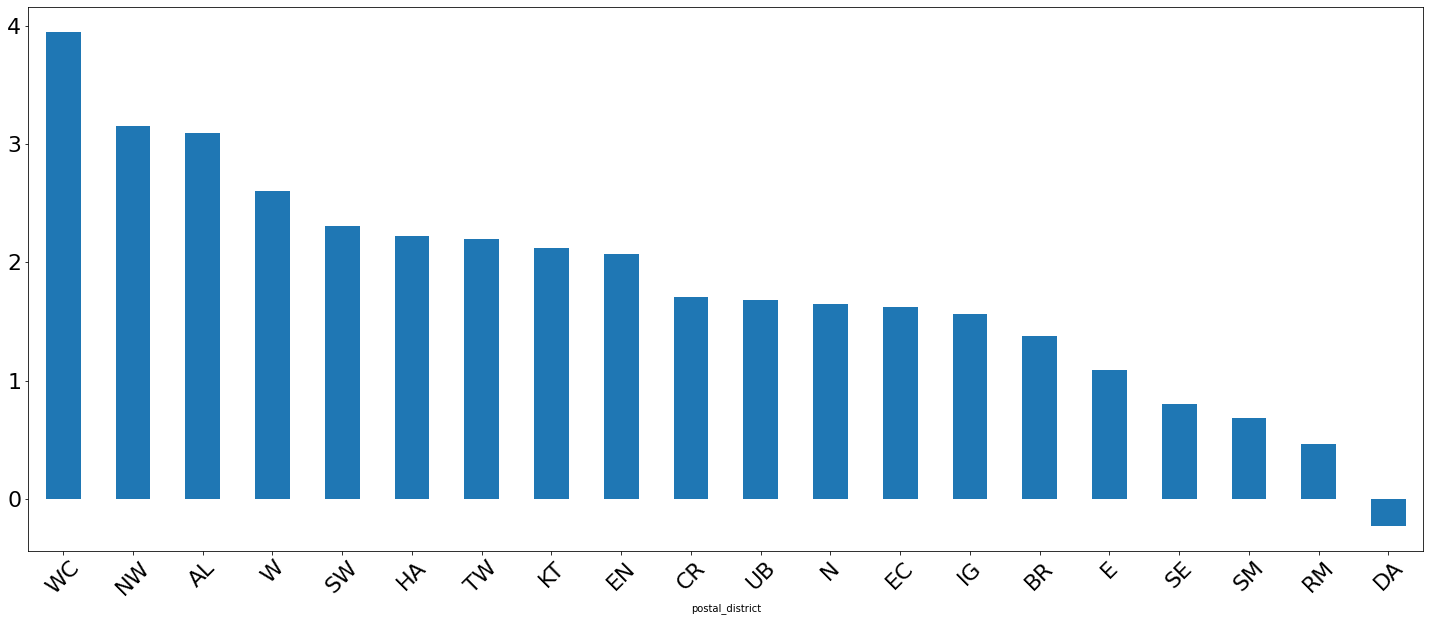

In [30]:
plot1 = remade2.groupby(['postal_district']).mean()['% asking_price_discount']  #group by postal district
plot1 = plot1.sort_values(ascending = False)

plot1.plot(x = "postal_district", y = "% asking_price_discount", kind = "bar", figsize=(25,10),
           fontsize=22, rot=45)

## Gross Average Asking Price Discount by London Postal District

<AxesSubplot:xlabel='postal_district'>

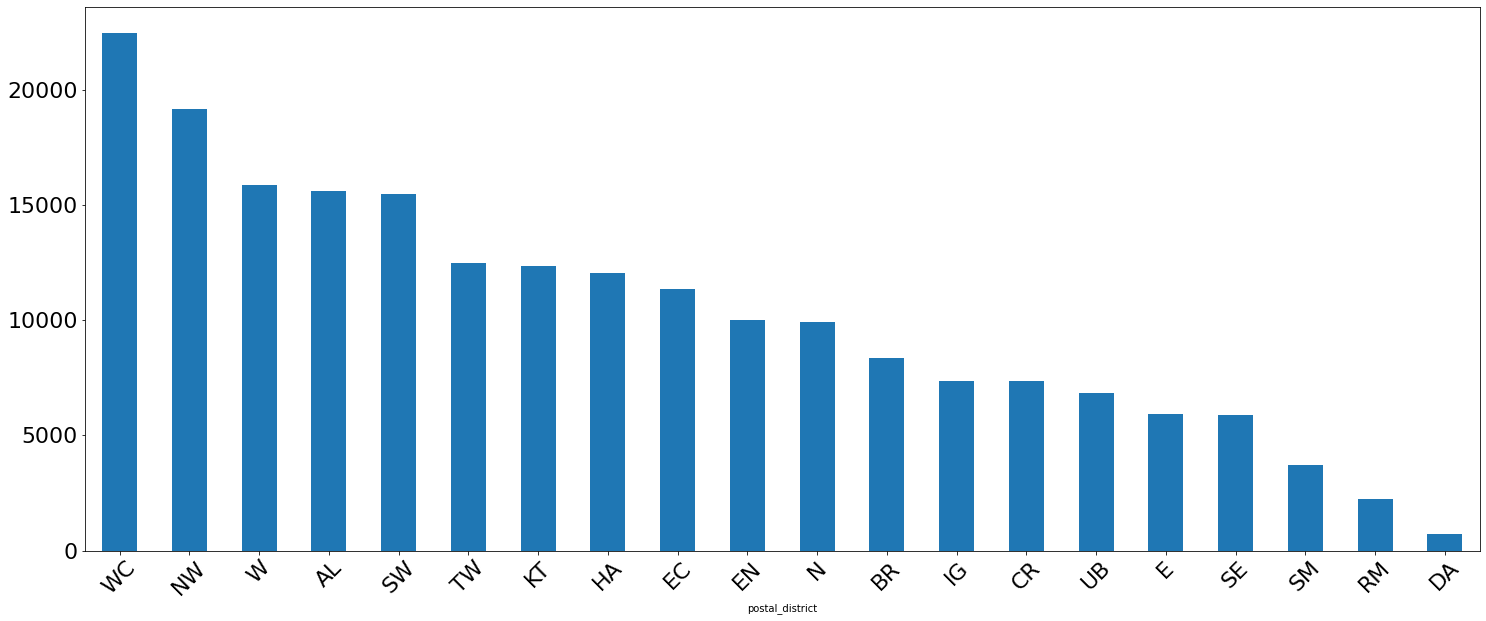

In [31]:
plot2 = remade2.groupby(['postal_district']).mean()['asking_price_discount']
plot2 = plot2.sort_values(ascending = False)

plot2.plot(x = "postal_district", y = "asking_price_discount", kind = "bar", figsize=(25,10),
           fontsize=22, rot=45)

In [32]:
remade2.groupby('postal_district').mean()[['asking_price_discount', '% asking_price_discount']].sample(10)

asking_price_discount  % asking_price_discount
postal_district                                                
N                          9905.815230                 1.647420
CR                         7360.513333                 1.708260
WC                        22450.000000                 3.947391
DA                          725.732692                -0.228058
SW                        15476.377278                 2.311393
EC                        11336.000000                 1.619500
TW                        12493.166935                 2.197024
EN                         9988.021463                 2.068985
E                          5913.036199                 1.091071
AL                        15617.414815                 3.094222

# Findings by Property Type


### % Average Asking Price Discount by Property Type

<AxesSubplot:title={'center':'% Average Asking Price Discount by London Postal District'}, xlabel='property_type'>

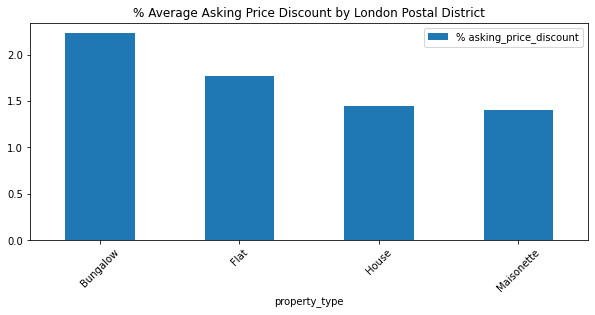

In [33]:
plot3 = remade2.groupby(['property_type']).mean()['% asking_price_discount'] #grouping by property type

plot3 = plot3.sort_values(ascending = False)  #sort to have an ordered bar chart

plot3.plot(x = "property_type", y = "asking_price_discount", kind = "bar", figsize=(10,4),
           fontsize=10, rot=45, title='% Average Asking Price Discount by London Postal District', legend=True)

### Gross Average Asking Price Discount by Property Type

<AxesSubplot:title={'center':'Average Asking Price Discount (GROSS) by Property Type'}, xlabel='property_type'>

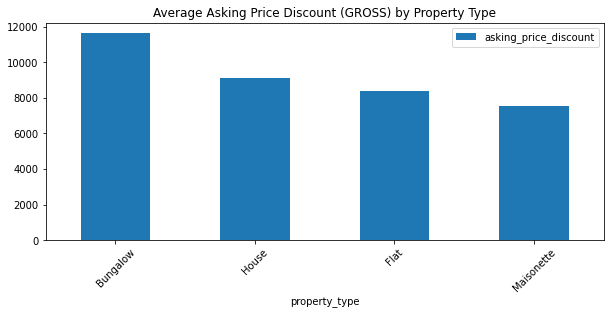

In [34]:
plot4 = remade2.groupby(['property_type']).mean()['asking_price_discount']
plot4 = plot4.sort_values(ascending = False)

plot4.plot(x = "property_type", y = "asking_price_discount", kind = "bar", figsize=(10,4),
           fontsize=10, rot=45, title='Average Asking Price Discount (GROSS) by Property Type', legend=True)

In [35]:
#property type grouping

remade2.groupby('property_type').mean()[['asking_price_discount', '% asking_price_discount']]

asking_price_discount  % asking_price_discount
property_type                                                
Bungalow                11630.452776                 2.229791
Flat                     8358.375673                 1.772608
House                    9102.487863                 1.444076
Maisonette               7553.521127                 1.398149

# Querying

## Format for easy querying

In [36]:
#this will reformat data so we can easily ask the question - ie: what is the APD for a particular area code across property types


choose_postcode = remade2.groupby(['postal_district', 'property_type']).mean()[['asking_price_discount', '% asking_price_discount' ]].round(2)

In [37]:
#this will reformat data so we can easily ask the question - what is the APD for a particular property type
#across all postal districts

choose_property_type = choose_postcode.reorder_levels(order=['property_type', 'postal_district'], axis=0).round(2)

## By Postal District

In [38]:
#example of how easy the quering is for all property types per postal district

choose_postcode.loc['AL']

asking_price_discount  % asking_price_discount
property_type                                                
Bungalow                    13242.50                     2.60
Flat                         5620.00                     2.12
House                       18398.94                     3.38
Maisonette                  10000.00                     4.40

## By Property Type

In [39]:
#example of how easy the querying is

choose_property_type.loc['Bungalow']

asking_price_discount  % asking_price_discount
postal_district                                                
AL                            13242.50                     2.60
BR                             8292.95                     1.84
CR                             7469.92                     1.94
DA                             2007.12                     0.30
E                             13555.00                     2.21
EN                            21346.76                     3.82
HA                            19290.44                     3.45
IG                             6270.76                     1.53
KT                            16148.68                     3.05
N                             14422.00                     2.82
NW                            28934.54                     4.88
RM                             5883.88                     1.22
SE                            17824.17                     5.02
SM                            12959.17                     2.47
SW                            37544.55                     6.11
TW                            16859.28                     2.88
UB                            16753.57                     3.21
W                             31112.50                     4.57

## By Property Type and Postal District


In [40]:
#querying with property type in combination with area code. 

choose_postcode['% asking_price_discount']['AL']['Bungalow']

2.6

## File to Export

In [41]:
#Export this as an excel file to non-technical stakeholder. Information can be found easily using excel filter.

choose_postcode.head(10)

asking_price_discount  % asking_price_discount
postal_district property_type                                                
AL              Bungalow                    13242.50                     2.60
                Flat                         5620.00                     2.12
                House                       18398.94                     3.38
                Maisonette                  10000.00                     4.40
BR              Bungalow                     8292.95                     1.84
                Flat                         3467.61                     0.78
                House                        9960.12                     1.60
                Maisonette                   -824.35                    -0.47
CR              Bungalow                     7469.92                     1.94
                Flat                         5154.66                     1.78

## Recommendations

In [42]:
choose_postcode.sort_values(by='% asking_price_discount', ascending=False).head()

asking_price_discount  % asking_price_discount
postal_district property_type                                                
WC              Maisonette                  75000.00                    10.34
EC              House                       70000.00                     9.33
SW              Bungalow                    37544.55                     6.11
SE              Bungalow                    17824.17                     5.02
NW              Bungalow                    28934.54                     4.88

<AxesSubplot:title={'center':'Highest % APD by Postal District/Property Type Combination'}, xlabel='postal_district,property_type'>

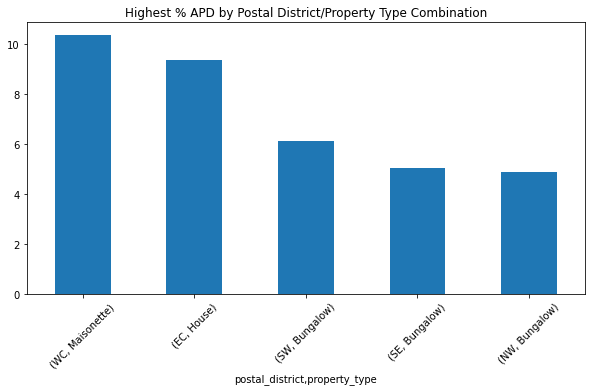

In [43]:
choose_postcode.sort_values(by='% asking_price_discount',ascending=False).head()['% asking_price_discount'].plot(kind='bar',rot=45, figsize=(10,5), title = 'Highest % APD by Postal District/Property Type Combination')

### With more time: 

- Check time difference between listing and sale price was realistic, if there was a several year gap it is likely that the listing price was not the current 'asking price' at the time of purchase.

- Capture more data - certain properties were sold more than once. A more complete dataset would give more accurate results.

### Caveats 

- Not all data has been used in the calculation. A more accurate prediction could be made with more time.

- No properties over a million. This is odd considering the London market


# Predicting Sale Price

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

In [46]:
#reimport data 

data = pd.read_csv("~/Desktop/Bricklane/property_sales_data.csv", delimiter='|')

#remove outliers

data = data.loc[data['price'] > 15000]

In [47]:
#keeping only sale price

data = data[data['event_type']=='sale'] 

In [48]:
#create copy to avoid copysetwarning

data_copy = data.copy()

In [49]:
data_copy['date'] = pd.to_datetime(data_copy['date'])

In [50]:
#drop null

data_copy = data_copy.dropna()

In [51]:
#keep only last sale

data_copy = data_copy.drop_duplicates(subset=['property_id'], keep='last')

In [52]:
#create copy to avoid copysetwarning

data_copy2 = data_copy.copy()

In [53]:
#create postal distict 

data_copy2['postal_district'] = data_copy2['postcode'].str.slice(0, 2)
data_copy2['postal_district'] = data_copy2.postal_district.str.replace('\d+', '')

In [54]:
#drop unecessary data

data_copy2 = data_copy2.drop(['Unnamed: 0','event_type','property_id','postcode','date'], axis=1)

In [55]:
#creating a construction time column/feature

data_copy2['date_started'] = data_copy2.construction_date.str[:4]
data_copy2['date_started'] = pd.to_numeric(data_copy2.date_started, errors='coerce').dropna()

data_copy2['date_finished'] = data_copy2.construction_date.str[5:]
data_copy2['date_finished'] = pd.to_numeric(data_copy2.date_finished, errors='coerce').dropna()

In [57]:
data_copy2.dropna(inplace=True)  #drop null values that where could no calculate construction time

In [58]:
#calculate new feature - construction time.

data_copy2['construction_time'] = data_copy2['date_finished'] - data_copy2['date_started']

In [59]:
#drop irrelevant columns

data_copy2.drop(['date_finished','date_started', 'construction_date'], axis =1, inplace=True)

In [60]:
data_copy2.head()

property_type  floor_area  bedroom_count  bathroom_count     price  \
4          House        82.0            3.0             1.0  375000.0   
7           Flat        43.4            1.0             0.0  263000.0   
11         House       114.0            3.0             0.0  495000.0   
14          Flat        53.0            2.0             1.0  325000.0   
21          Flat        95.0            3.0             0.0  355000.0   

   postal_district  construction_time  
4               AL                8.0  
7               AL                7.0  
11              AL               16.0  
14              BR                3.0  
21              BR               16.0

In [61]:
#label encode categorical variables 

labelencoder=LabelEncoder()
for column in ['property_type', 'postal_district' ]:
    data_copy2[column] = labelencoder.fit_transform(data_copy2[column])

In [62]:
X = data_copy2[['property_type', 'floor_area', 'bedroom_count', 'bathroom_count',
               'postal_district', 'construction_time' ]]

Y = data_copy2['price']

In [63]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size =0.2)

In [64]:
#initiate model instance

model = LinearRegression()

In [65]:
#fit and predict

model = model.fit(X_train, Y_train)
ypred = model.predict(X_test)

In [66]:
#calculate error

from sklearn.metrics import mean_absolute_error

mean_absolute_error(ypred, Y_test)

104531.3375963275

### Normalising features

In [67]:
#normalise so they are all on same scale and there is no undue weight given to bigger values

from sklearn import preprocessing

x = X.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)


In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size =0.2)

In [69]:
#this actually makes the model perform worse

model = LinearRegression()
model = model.fit(X_train, Y_train)
ypred = model.predict(X_test)
mean_absolute_error(ypred, Y_test)

107168.8894850209

### Next Steps

- Prediction could be improved significantly, one thing I will look into next is creating a feature which gives the latest listing price, as this will ber very indicative in predicting the sale price